In [1]:
#coding=utf-8
import pandas as pd
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.utils import to_categorical
%matplotlib inline

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../stock50.csv')
train.head()

,Stock_num,Date,Open,High,Min,Close,Stock_trade
0,50,20170103,67.69,67.88,67.51,67.88,2331
1,50,20170104,67.98,68.07,67.74,67.84,4284
2,50,20170105,67.84,68.45,67.79,68.45,4573
3,50,20170106,68.40,68.69,68.40,68.59,3752
4,50,20170109,68.69,68.87,68.26,68.40,5038


In [3]:
def normalize(df):
    norm = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return norm
def train_windows(df, ref_day=5, predict_day=1):
    X_train, Y_train = [], []
    for i in range(df.shape[0]-predict_day-ref_day):
        X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        Y_train.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day]["y"]))
    return np.array(X_train), np.array(Y_train)
def lstm_stock_model(shape):
    model = Sequential()
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(5,activation='linear'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error'])
    model.summary()
    return model

In [4]:
train = train.dropna()
train['y'] = train['Close'].shift(-1)
#train = type_result(train)
train.iloc[:,2:4] = normalize(train.iloc[:,2:4])
train.head()

,Stock_num,Date,Open,High,Min,Close,Stock_trade,y
0,50,20170103,-0.554804,-0.554775,67.51,67.88,2331,67.84
1,50,20170104,-0.538826,-0.544393,67.74,67.84,4284,68.45
2,50,20170105,-0.546539,-0.523628,67.79,68.45,4573,68.59
3,50,20170106,-0.515685,-0.510513,68.40,68.59,3752,68.40
4,50,20170109,-0.499707,-0.500677,68.26,68.40,5038,68.35


In [5]:
train['Date'] = pd.to_datetime(train['Date'], format='%Y%m%d')
train['weekday'] = train['Date'].apply(lambda x: x.day)
train['year'] = train['Date'].apply(lambda x: x.year)
train['Month'] = train['Date'].apply(lambda x: x.month)
test = train[-30:]
train = train[(train['year']==2017)|((train['year']==2018)&(train['Month']<=3))|((train['year']==2018)&(train['Month']==4)&(train['weekday']<=27))]
#train & test
train = train.reset_index()
test = test.reset_index()
train = train.dropna()

In [6]:
test.head()

,index,Stock_num,Date,Open,High,Min,Close,Stock_trade,y,weekday,year,Month
0,292,50,2018-03-16,0.343819,0.337028,83.10,83.90,5510,83.85,16,2018,3
1,293,50,2018-03-19,0.324535,0.331563,83.45,83.85,2035,83.80,19,2018,3
2,294,50,2018-03-20,0.299742,0.315170,83.20,83.80,2895,83.85,20,2018,3
3,295,50,2018-03-21,0.332799,0.331563,83.60,83.85,4891,83.55,21,2018,3
4,296,50,2018-03-22,0.343819,0.358886,83.45,83.55,3429,82.10,22,2018,3


In [7]:
train.drop(['Stock_num','High','Min','Open','Date','weekday','year','Month',"index"], axis=1, inplace=True)
test.drop(['Stock_num','Date','High','Min','Open','weekday','year','Month','index'], axis=1, inplace=True)
train.head()

,Close,Stock_trade,y
0,67.88,2331,67.84
1,67.84,4284,68.45
2,68.45,4573,68.59
3,68.59,3752,68.40
4,68.40,5038,68.35


In [8]:
X_train, Y_train = train_windows(train, 5, 1)
X_test, Y_test = train_windows(test, 5, 1)

In [9]:
model = lstm_stock_model(X_train.shape)
callback = EarlyStopping(monitor="mean_absolute_error", patience=10, verbose=1, mode="auto")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 256)            265216    
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 1)              257       
_________________________________________________________________
flatten_1 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 790,821
Trainable params: 790,821
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(X_train, Y_train, epochs=1000, batch_size=5, validation_split=0.1, callbacks=[callback],shuffle=True)

Train on 283 samples, validate on 32 samples
Epoch 1/1000
283/283 [==============================] - 4s 13ms/step - loss: 46.0563 - mean_absolute_error: 46.0563 - val_loss: 21.8721 - val_mean_absolute_error: 21.8721
Epoch 2/1000
283/283 [==============================] - 3s 11ms/step - loss: 5.4499 - mean_absolute_error: 5.4499 - val_loss: 2.9663 - val_mean_absolute_error: 2.9663
Epoch 3/1000
283/283 [==============================] - 3s 11ms/step - loss: 3.9801 - mean_absolute_error: 3.9801 - val_loss: 8.6022 - val_mean_absolute_error: 8.6022
Epoch 4/1000
283/283 [==============================] - 3s 12ms/step - loss: 4.1501 - mean_absolute_error: 4.1501 - val_loss: 4.1850 - val_mean_absolute_error: 4.1850
Epoch 5/1000
283/283 [==============================] - 3s 11ms/step - loss: 4.0448 - mean_absolute_error: 4.0448 - val_loss: 3.1381 - val_mean_absolute_error: 3.1381
Epoch 6/1000
283/283 [==============================] - 3s 11ms/step - loss: 4.2006 - mean_absolute_error: 4.2006 - 

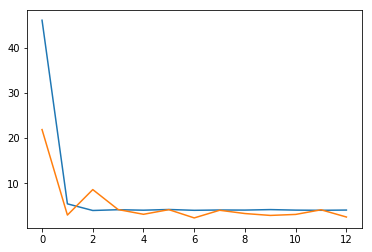

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])